Önceki bölümde, Spark Veri Çerçevelerinin temel kavramlarını
öğrendik ve bunları büyük veri analizinde nasıl kullanabileceğimizi
gördük. Bu bölümde, bir adım daha ileri giderek verilerdeki eksik
değerlerin nasıl ele alınacağını ve Spark Veri Çerçeveleri ile korelasyon
analizini öğreneceğiz. Bu kavramlar, makine öğrenimi ve keşifsel
veri analizi için veri hazırlamada bize yardımcı olacak. Okuyucuya
bir bağlam sağlamak için bu kavramları kısaca ele alacağız, ancak
odak noktamız bunların Spark Veri Çerçeveleri ile uygulanması. Bu
bölümdeki alıştırmalar için de önceki bölümde kullandığımız aynı Iris
veri kümesini kullanacağız. Ancak Iris veri kümesinde eksik değer
bulunmadığından, orijinal veri kümesinden Sepallength sütunundan
iki girişi ve Petallength sütunundan bir girişi rastgele kaldırdık.
Böylece, artık eksik değerleri olan bir veri kümemiz var ve PySpark
kullanarak bu eksik değerleri nasıl ele alacağımızı öğreneceğiz. Ayrıca,
Iris veri setindeki değişkenler arasındaki korelasyona, korelasyon
katsayılarını ve korelasyon matrisini hesaplayarak bakacağız.

In [ ]:
# Import PySpark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

#Create SparkSession
spark = SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate()
sc=spark.sparkContext
sqlc = SQLContext(sc)

from google.colab import files
uploaded = files.upload()
df = sqlc.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('iris_missing_data.csv')
type(df)
df.show()

Saving iris_missing_data.csv to iris_missing_data.csv
+---+------------+-----------+------------+-----------+-----------+
| Id|sepal_length|sepal_width|petal_length|petal_width|    species|
+---+------------+-----------+------------+-----------+-----------+
|  1|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|  2|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|  3|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|  4|        NULL|        3.1|         1.5|        0.2|Iris-setosa|
|  5|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
|  6|         5.4|        3.9|         1.7|        0.4|Iris-setosa|
|  7|         4.6|        3.4|         1.4|        0.3|Iris-setosa|
|  8|         5.0|        3.4|         1.5|        0.2|Iris-setosa|
|  9|         4.4|        2.9|         1.4|        0.2|Iris-setosa|
| 10|         4.9|        3.1|        NULL|        0.1|Iris-setosa|
| 11|         5.4|        3.7|         1.5|        0.2|Iris-se

**Kayıp Gözlemler**

Eksik veri yüzdesine bağlı olarak, eksik değerler veri hazırlama ve
keşifsel analizde önemli bir zorluk oluşturabilir. Bu nedenle, veri
analizine başlamadan önce eksik veri yüzdesini hesaplamak önemlidir.
Aşağıdaki alıştırmada, PySpark DataFrame’lerindeki eksik değer girişlerinin
sayısını nasıl tespit edip hesaplayacağımızı öğreneceğiz.


In [ ]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(),
c)).alias(c) for c in df.columns]).show()

df.filter(col('sepal_length').isNull()).count()

+---+------------+-----------+------------+-----------+-------+
| Id|sepal_length|sepal_width|petal_length|petal_width|species|
+---+------------+-----------+------------+-----------+-------+
|  0|          11|          7|           8|          9|      0|
+---+------------+-----------+------------+-----------+-------+



11

**Tüm Veri Çerçevesi Sütunlarındaki Eksik Değerleri Sayma**

Bu alıştırmada, bir PySpark DataFrame’in tüm sütunlarında bulunan
eksik değerleri sayacağız:

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(i) | col(i).isNull(), i)).alias(i) for i in
df.columns]).show()

df.describe().show(1)

+---+------------+-----------+------------+-----------+-------+
| Id|sepal_length|sepal_width|petal_length|petal_width|species|
+---+------------+-----------+------------+-----------+-------+
|  0|          11|          7|           8|          9|      0|
+---+------------+-----------+------------+-----------+-------+

+-------+---+------------+-----------+------------+-----------+-------+
|summary| Id|sepal_length|sepal_width|petal_length|petal_width|species|
+-------+---+------------+-----------+------------+-----------+-------+
|  count|150|         139|        143|         142|        141|    150|
+-------+---+------------+-----------+------------+-----------+-------+
only showing top 1 row



**Veri Çerçevesinden Eksik Değer Kayıtlarını Getirme**

Aşağıdaki kodu kullanarak PySpark DataFrame’deki eksik değer
girişlerini içeren kayıtları da filtreleyebiliriz:

In [ ]:
df.where(col('sepal_length').isNull()).show()

df.select('sepal_length').dropna().count()

df.dropna().count()

+---+------------+-----------+------------+-----------+---------------+
| Id|sepal_length|sepal_width|petal_length|petal_width|        species|
+---+------------+-----------+------------+-----------+---------------+
|  4|        NULL|        3.1|         1.5|        0.2|    Iris-setosa|
| 14|        NULL|        3.0|         1.1|        0.1|    Iris-setosa|
| 19|        NULL|        3.8|         1.7|        0.3|    Iris-setosa|
| 28|        NULL|        3.5|         1.5|        0.2|    Iris-setosa|
| 52|        NULL|        3.2|         4.5|        1.5|Iris-versicolor|
| 75|        NULL|        2.9|         4.3|        1.3|Iris-versicolor|
| 83|        NULL|        2.7|         3.9|        1.2|Iris-versicolor|
|100|        NULL|        2.8|         4.1|        1.3|Iris-versicolor|
|126|        NULL|        3.2|         6.0|        1.8| Iris-virginica|
|131|        NULL|        2.8|         6.1|        1.9| Iris-virginica|
|143|        NULL|        2.7|         5.1|       NULL| Iris-vir

119

In [ ]:
df.dropna().count()

119

In [ ]:
df.where(col('sepal_length').isNull()).show()

+---+------------+-----------+------------+-----------+---------------+
| Id|sepal_length|sepal_width|petal_length|petal_width|        species|
+---+------------+-----------+------------+-----------+---------------+
|  4|        NULL|        3.1|         1.5|        0.2|    Iris-setosa|
| 14|        NULL|        3.0|         1.1|        0.1|    Iris-setosa|
| 19|        NULL|        3.8|         1.7|        0.3|    Iris-setosa|
| 28|        NULL|        3.5|         1.5|        0.2|    Iris-setosa|
| 52|        NULL|        3.2|         4.5|        1.5|Iris-versicolor|
| 75|        NULL|        2.9|         4.3|        1.3|Iris-versicolor|
| 83|        NULL|        2.7|         3.9|        1.2|Iris-versicolor|
|100|        NULL|        2.8|         4.1|        1.3|Iris-versicolor|
|126|        NULL|        3.2|         6.0|        1.8| Iris-virginica|
|131|        NULL|        2.8|         6.1|        1.9| Iris-virginica|
|143|        NULL|        2.7|         5.1|       NULL| Iris-vir

**Spark Veri Çerçevelerinde Eksik Değerlerin İşlenmesi**

Eksik değer işleme, veri biliminin karmaşık alanlarından biridir. Eksik
veri türüne ve mevcut iş kullanım senaryosuna bağlı olarak, eksik
değerleri işlemek için kullanılan çeşitli teknikler vardır. Bu yöntemler,
basit mantık tabanlı yöntemlerden regresyon ve KNN gibi gelişmiş
istatistiksel yöntemlere kadar uzanır. Ancak, eksik değerleri ele
almak için kullanılan yöntemden bağımsız olarak, eksik değer verileri
üzerinde aşağıdaki iki işlemden birini gerçekleştireceğiz:

- Verilerden eksik değerlere sahip kayıtları kaldırma

- Eksik değer girişlerini sabit bir değerle yükleme


Bu bölümde, bu iki işlemin de PySpark DataFrame’leri ile nasıl
yapılacağını inceleyeceğiz.

In [ ]:
df.select('sepal_length').dropna().count()

df.dropna().count()

119

In [ ]:
y = df.select('sepal_length','petal_length').fillna(1)
y.select([count(when(isnan(i) | col(i).isNull(), i)).alias(i) for i in
y.columns]).show()


+------------+------------+
|sepal_length|petal_length|
+------------+------------+
|           0|           0|
+------------+------------+



In [ ]:
z = df.fillna(1)
z.select([count(when(isnan(k) | col(k).isNull(), k)).alias(k) for k in
z.columns]).show()

+---+------------+-----------+------------+-----------+-------+
| Id|sepal_length|sepal_width|petal_length|petal_width|species|
+---+------------+-----------+------------+-----------+-------+
|  0|           0|          0|           0|          0|      0|
+---+------------+-----------+------------+-----------+-------+



**Korelasyon**

Korelasyon, iki sayısal değişken arasındaki ilişki düzeyinin istatistiksel
bir ölçüsüdür. İki değişkenin birbiriyle ne kadar yakın ilişkili olduğuna
dair bir fikir verir. Örneğin, yaş ve gelir oldukça yakın ilişkili değişkenlerdir.

Ortalama gelirin belirli bir eşik değer aralığında yaşla birlikte
arttığı gözlemlenmiştir. Dolayısıyla, yaş ve gelirin birbiriyle pozitif
korelasyona sahip olduğunu varsayabiliriz.


Bu ilişkiyi hesaplamak için kullanılan en yaygın metrik, yaygın olarak
Pearson korelasyon katsayısı veya kısaca korelasyon katsayısı olarak
bilinen Pearson Ürün-Moment Korelasyonu’dur. Adını mucidi Karl
Pearson’dan almıştır.

Pearson korelasyon katsayısı, iki değişkenin kovaryansının standart
sapmalarının çarpımına bölünmesiyle hesaplanır. Korelasyon değeri
-1 ile +1 arasındadır; 1 veya -1’e yakın değerler güçlü ilişkiyi, 0’a
yakın değerler ise zayıf ilişkiyi gösterir. Katsayının (+, -) işareti,
ilişkinin pozitif (her iki değişken birlikte artar/azalır) veya negatif
(tersi) olduğunu gösterir.


Korelasyon, istatistiksel analizde büyük önem taşır, çünkü verileri
açıklamaya yardımcı olur ve bazen değişkenler arasındaki tahmini
ilişkileri vurgular. Bu bölümde, PySpark’ta değişkenler arasındaki
korelasyonun nasıl hesaplanacağını ve bir korelasyon matrisinin nasıl
hesaplanacağını öğreneceğiz.

**Korelasyonun Hesaplanması**

Bu alıştırmada, iki sayısal değişken arasındaki Pearson korelasyon katsayısının
değerini ve PySpark DataFrame’imizin tüm sayısal sütunları
için bir korelasyon matrisini hesaplayacağız. Korelasyon matrisi, tüm
sayısal sütunların birbirleriyle olan korelasyonunu görselleştirmemize
yardımcı olur:

In [ ]:
df.corr('sepal_length', 'sepal_width')

-0.07534137711178807

In [ ]:
from pyspark.mllib.stat import Statistics
import pandas as pd

In [ ]:
z = df.fillna(1)

In [ ]:
a = z.drop('Species')

In [ ]:
features = a.rdd.map(lambda row: row[0:])
correlation_matrix = Statistics.corr(features, method="pearson")

In [ ]:
correlation_df = pd.DataFrame(correlation_matrix)

 **PySpark ile Eksik Değer İşleme ve Korelasyon Analizi
DataFrames**

Bu etkinlikte, Iris veri kümesindeki eksik değerleri tespit edip işleyeceğiz.
Ayrıca, korelasyon matrisini hesaplayacak ve güçlü korelasyonlar
gösteren değişkenleri birbirleriyle çizip grafiğe doğrusal bir çizgi
yerleştirerek doğrulayacağız:

In [ ]:
correlation_df.index, correlation_df.columns = a.columns, a.columns

In [ ]:
correlation_df

,Id,sepal_length,sepal_width,petal_length,petal_width
Id,1.000000,0.388501,-0.284608,0.829438,0.867369
sepal_length,0.388501,1.000000,-0.079383,0.421156,0.470135
sepal_width,-0.284608,-0.079383,1.000000,-0.217679,-0.251430
petal_length,0.829438,0.421156,-0.217679,1.000000,0.896668
petal_width,0.867369,0.470135,-0.251430,0.896668,1.000000


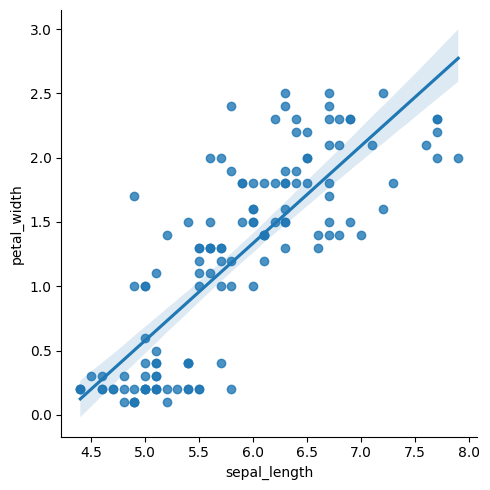

In [ ]:
data = df.toPandas()
sns.lmplot(x = "sepal_length", y = "petal_width", data = data)
plt.show()

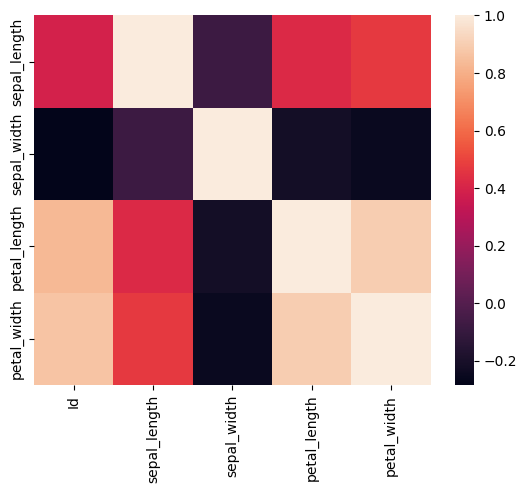

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(correlation_df[1:])
plt.show()